### Analyis behavior data of aminal in the VR

In [1]:
import glob
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
### let's write a function to get the reward rate for each file
def get_reward_rate_perday(datapath):
    '''
    This function takes in the path to the data file and returns the reward rate
    '''
    with open(datapath) as f:
        content = f.readlines()
        
    #read all the lines with key words 'Reward_delivered'
    reward_delivered = [x for x in content if 'Reward_delivered' in x]
    #get the time in the first line and the last line
    first_reward_time = reward_delivered[0].split(' ')[1]
    last_reward_time = reward_delivered[-1].split(' ')[1]
    #convert str to time
    first_reward_time = datetime.strptime(first_reward_time, '%H:%M:%S.%f')
    last_reward_time = datetime.strptime(last_reward_time, '%H:%M:%S.%f')
    #calculate the time difference
    time_diff = last_reward_time - first_reward_time
    #convert timedelta to hours   
    time_diff = time_diff.total_seconds()/3600
    #calculte the reward rate per hour
    reward_rate = len(reward_delivered)/time_diff
    
    reward_rate = reward_rate/60 #convert to reward rate per minute
    
    return reward_rate


In [3]:
def get_reward_rate_crossday(trainingpath, exppath):
    '''
    Get the reward rate across training and experiment days
    Input: datafolder, the path to the folder containing all the data
    Output: reward_rate, a dictionary containing the reward rate for training and experiment days
    '''
    reward_rate = {}
    #load all txt under trainigpath
    training_files = glob.glob(trainingpath + '/*.txt')
    #sort the files according to the date
    training_files.sort()
    #for each file, get the reward rate
    reward_rate_training = []
    for file in training_files:
        reward_rate_training.append(get_reward_rate_perday(file))

    #load all txt under expath
    exp_files = glob.glob(exppath + '/*.txt')
    #sort the files according to the date
    exp_files.sort()
    #for each file, get the reward rate
    reward_rate_exp = []
    for file in exp_files:
        reward_rate_exp.append(get_reward_rate_perday(file))
        
    reward_rate['training'] = reward_rate_training
    reward_rate['exp'] = reward_rate_exp
    
    return reward_rate

In [ ]:
fig = plt.figure(figsize=(3, 2), dpi=300)
labelsize = 10
ticksize = 8
ax = fig.add_subplot(111)

trainingpath = '/home/zilong/Desktop/2D2P/Data/162/162_training'
exppath = '/home/zilong/Desktop/2D2P/Data/162/162_exp'
reward_rate = get_reward_rate_crossday(trainingpath, exppath)

#plot the reward rate with training in orange 
x_training = np.arange(len(reward_rate['training']))
ax.plot(x_training, reward_rate['training'], marker='o', markersize=5, linestyle='--', color='#F18D00', label='mouse 162')
#plot the reward rate with exp in orange
x_exp = np.arange(len(reward_rate['exp'])) + len(reward_rate['training'])
ax.plot(x_exp, reward_rate['exp'], marker='d', markersize=5, linestyle='-', color='#F18D00')
#connect the two lines
ax.plot([len(reward_rate['training'])-1, len(reward_rate['training'])], [reward_rate['training'][-1], reward_rate['exp'][0]], color='#F18D00', linestyle='--')

trainingpath = '/home/zilong/Desktop/2D2P/Data/162/162_training'
exppath = '/home/zilong/Desktop/2D2P/Data/162/162_exp'
reward_rate = get_reward_rate_crossday(trainingpath, exppath)

###
trainingpath = '/home/zilong/Desktop/2D2P/Data/163/163_training'
exppath = '/home/zilong/Desktop/2D2P/Data/163/163_exp'
reward_rate = get_reward_rate_crossday(trainingpath, exppath)
#plot the reward rate with training in orange 
x_training = np.arange(len(reward_rate['training']))
ax.plot(x_training, reward_rate['training'], marker='o', markersize=5, linestyle='--', color='#009FB9', label='mouse 163')
#plot the reward rate with exp in orange
x_exp = np.arange(len(reward_rate['exp'])) + len(reward_rate['training'])
ax.plot(x_exp, reward_rate['exp'], marker='d', markersize=5, linestyle='-', color='#009FB9')
#connect the two lines
ax.plot([len(reward_rate['training'])-1, len(reward_rate['training'])], [reward_rate['training'][-1], reward_rate['exp'][0]], color='#009FB9', linestyle='--')

#xticks as int
ax.set_xticks(np.arange(0,11, 2))
ax.legend(fontsize=ticksize, loc='upper left')
ax.set_xlabel('Sessions', fontsize=labelsize)
ax.set_ylabel('Reward rate (rewards/h)', fontsize=labelsize)

In [4]:
#let's write a function to get the average speed of the animal perday
def get_speed_perday(datapath):
    
    with open(datapath) as f:
        content = f.readlines()
        
    #get all lines with 'X ='
    x_lines = [x for x in content if 'X=' in x]

    #get the values of x and z. The values are after X= and Z=, and before the next space
    x_values = [float(x.split('X=')[1].split(' ')[0]) for x in x_lines]
    z_values = [float(x.split('Z=')[1].split(' ')[0]) for x in x_lines]

    #get the times  
    times = [x.split(' ')[1] for x in x_lines]
    #convert str to time
    times = [datetime.strptime(x, '%H:%M:%S.%f') for x in times]

    #normalize the values to 0-1
    x_values = (x_values - np.min(x_values))/(np.max(x_values) - np.min(x_values))
    z_values = (z_values - np.min(z_values))/(np.max(z_values) - np.min(z_values))

    #calculate speed as the distance between two points divided by the time difference, with offset as 10 points
    #set the offset to 10 to avoid the time diffrence of successive points to be 0
    offset = 10
    x_diff = x_values[offset:] - x_values[:-offset]
    z_diff = z_values[offset:] - z_values[:-offset]
    time_diff = [(times[i+offset] - times[i]).total_seconds() for i in range(len(times)-offset)]
    speed = np.sqrt(x_diff**2 + z_diff**2)/time_diff
    
    #ignore inf and nan
    speed = [x for x in speed if x != np.inf and x != np.nan]

    return 60*np.mean(speed)

In [5]:
#write a function of get_speed_crossday
def get_speed_crossday(trainingpath, exppath):
    '''
    Get the speed across training and experiment days
    Input: datafolder, the path to the folder containing all the data
    Output: speed, a dictionary containing the speed for training and experiment days
    '''
    speed = {}
    #load all txt under trainigpath
    training_files = glob.glob(trainingpath + '/*.txt')
    
    #sort the files according to the date
    training_files.sort()
    #for each file, get the reward rate
    speed_training = []
    for file in training_files:
        speed_training.append(get_speed_perday(file))

    #load all txt under expath
    exp_files = glob.glob(exppath + '/*.txt')
    #sort the files according to the date
    exp_files.sort()
    #for each file, get the reward rate
    speed_exp = []
    for file in exp_files:
        speed_exp.append(get_speed_perday(file))
        
    speed['training'] = speed_training
    speed['exp'] = speed_exp
    
    return speed

In [ ]:
#plot the trajectory
fig = plt.figure(figsize=(3, 2), dpi=300)
labelsize = 10
ticksize = 8
ax = fig.add_subplot(111)

#get speed for mouse 162
trainingpath = '/home/zilong/Desktop/2D2P/Data/162/162_training'
exppath = '/home/zilong/Desktop/2D2P/Data/162/162_exp'

speed = get_speed_crossday(trainingpath, exppath)

#plot the speed with training in orange
x_training = np.arange(len(speed['training']))
ax.plot(x_training, speed['training'], marker='o', markersize=5, linestyle='--', color='#F18D00', label='mouse 162')
#plot the speed with exp in orange
x_exp = np.arange(len(speed['exp'])) + len(speed['training'])
ax.plot(x_exp, speed['exp'], marker='d', markersize=5, linestyle='-', color='#F18D00')
#connect the two lines
ax.plot([len(speed['training'])-1, len(speed['training'])], [speed['training'][-1], speed['exp'][0]], color='#F18D00', linestyle='--')

#get speed for mouse 163
trainingpath = '/home/zilong/Desktop/2D2P/Data/163/163_training'
exppath = '/home/zilong/Desktop/2D2P/Data/163/163_exp'

speed = get_speed_crossday(trainingpath, exppath)

#plot the speed with training in orange
x_training = np.arange(len(speed['training']))
ax.plot(x_training, speed['training'], marker='o', markersize=5, linestyle='--', color='#009FB9', label='mouse 163')
#plot the speed with exp in orange
x_exp = np.arange(len(speed['exp'])) + len(speed['training'])
ax.plot(x_exp, speed['exp'], marker='d', markersize=5, linestyle='-', color='#009FB9')
#connect the two lines
ax.plot([len(speed['training'])-1, len(speed['training'])], [speed['training'][-1], speed['exp'][0]], color='#009FB9', linestyle='--')

#xticks as int
ax.set_xticks(np.arange(0,11, 2))

ax.legend(fontsize=ticksize, loc='upper left')
ax.set_xlabel('Sessions', fontsize=labelsize)
ax.set_ylabel('Speed (cm/s)', fontsize=labelsize)

    
    

In [6]:
def get_straightness_perday(filepath):
    '''
    This function takes in the path to the data file and returns the straightness
    '''
    with open(filepath) as f:
        content = f.readlines()
        
    #get all lines with 'X ='
    x_lines = [x for x in content if 'X=' in x]

    #get the values of x and z. The values are after X= and Z=, and before the next space
    x_values = [float(x.split('X=')[1].split(' ')[0]) for x in x_lines]
    z_values = [float(x.split('Z=')[1].split(' ')[0]) for x in x_lines]

    #get min and max of x and z
    x_min = np.min(x_values); x_max = np.max(x_values)
    z_min = np.min(z_values); z_max = np.max(z_values)

    # initialize an empty dictionary
    content_chunks = {}

    # loop through each line in the file
    ind = 0
    key = 'chunk' + str(ind)
    content_chunks[key] = []
    for line in content:
        #if current line contains 'Reward_delivered', then create a new key in the dictionary named chunk ind
        if 'Reward_delivered' in line:
            ind += 1
            key = 'chunk' + str(ind)
            content_chunks[key] = []

        #store the line in the current chunk
        content_chunks[key].append(line)

    #in each chunk, get all lines with Key 'X=' in that line
    straightness_list = []
    for content_i in content_chunks:
        x_lines = [x for x in content_chunks[content_i] if 'X=' in x]

        #get the values of x and z. The values are after X= and Z=, and before the next space
        x_values = [float(x.split('X=')[1].split(' ')[0]) for x in x_lines]
        z_values = [float(x.split('Z=')[1].split(' ')[0]) for x in x_lines]
        
        #normalize x_values and z_values according to x_min and x_max;  z_min and z_max
        x_values = (x_values - x_min)/(x_max - x_min)
        z_values = (z_values - z_min)/(z_max - z_min)
        
        #get the Eucledian distance between the start and end points
        x_diff = x_values[-1] - x_values[0]
        z_diff = z_values[-1] - z_values[0]
        euc_distance = np.sqrt(x_diff**2 + z_diff**2)
        
        #get the integrated distance as the sum of the distance between successive points
        #using np.diff to get the difference between successive points
        x_diff = np.diff(x_values)
        z_diff = np.diff(z_values)
        integrated_distance = np.sum(np.sqrt(x_diff**2 + z_diff**2))
        
        #get the straightness of the trajectory as the ratio of integrated distance and euc_distance
        if euc_distance == 0:
            continue
        
        straightness = integrated_distance/euc_distance
        
        straightness_list.append(straightness)
        
        #print('straightness for chunk ' + content_i + ' is ' + str(straightness))
        
    return np.mean(straightness_list)

In [7]:
def get_straightness_crossday(trainingpath, exppath):
    '''
    Get the straightness across training and experiment days
    Input: datafolder, the path to the folder containing all the data
    Output: straightness, a dictionary containing the straightness for training and experiment days
    '''
    straightness = {}
    #load all txt under trainigpath
    training_files = glob.glob(trainingpath + '/*.txt')
    #sort the files according to the date
    training_files.sort()
    #for each file, get the reward rate
    straightness_training = []
    for file in training_files:
        straightness_training.append(get_straightness_perday(file))

    #load all txt under expath
    exp_files = glob.glob(exppath + '/*.txt')
    #sort the files according to the date
    exp_files.sort()
    #for each file, get the reward rate
    straightness_exp = []
    for file in exp_files:
        straightness_exp.append(get_straightness_perday(file))
        
    straightness['training'] = straightness_training
    straightness['exp'] = straightness_exp
    
    return straightness

In [ ]:
#plot the straightness

fig = plt.figure(figsize=(3, 2), dpi=300)
labelsize = 10
ticksize = 8
ax = fig.add_subplot(111)

#get straightness for mouse 162
trainingpath = '/home/zilong/Desktop/2D2P/Data/162/162_training'
exppath = '/home/zilong/Desktop/2D2P/Data/162/162_exp'

straightness = get_straightness_crossday(trainingpath, exppath)

#plot the straightness with training in orange
x_training = np.arange(len(straightness['training']))
ax.plot(x_training, straightness['training'], marker='o', markersize=5, linestyle='--', color='#F18D00', label='mouse 162')
#plot the straightness with exp in orange
x_exp = np.arange(len(straightness['exp'])) + len(straightness['training'])
ax.plot(x_exp, straightness['exp'], marker='d', markersize=5, linestyle='-', color='#F18D00')
#connect the two lines  
ax.plot([len(straightness['training'])-1, len(straightness['training'])], [straightness['training'][-1], straightness['exp'][0]], color='#F18D00', linestyle='--')

#get straightness for mouse 163
trainingpath = '/home/zilong/Desktop/2D2P/Data/163/163_training'
exppath = '/home/zilong/Desktop/2D2P/Data/163/163_exp'

straightness = get_straightness_crossday(trainingpath, exppath)

#plot the straightness with training in orange
x_training = np.arange(len(straightness['training']))
ax.plot(x_training, straightness['training'], marker='o', markersize=5, linestyle='--', color='#009FB9', label='mouse 163')
#plot the straightness with exp in orange
x_exp = np.arange(len(straightness['exp'])) + len(straightness['training'])
ax.plot(x_exp, straightness['exp'], marker='d', markersize=5, linestyle='-', color='#009FB9')
#connect the two lines
ax.plot([len(straightness['training'])-1, len(straightness['training'])], [straightness['training'][-1], straightness['exp'][0]], color='#009FB9', linestyle='--')

#xticks as int
ax.set_xticks(np.arange(0,11, 2))
ax.legend(fontsize=ticksize, loc='upper right')
ax.set_xlabel('Sessions', fontsize=labelsize)
ax.set_ylabel('Straightness', fontsize=labelsize)
ax.set_ylim([0, 20])

    

In [8]:
#def a function of getting all the three outcomes across days
def get_all_outcomes(trainingpath, exppath):
    '''
    Get the reward rate, speed and straightness across training and experiment days
    Input: datafolder, the path to the folder containing all the data
    Output: outcomes, a dictionary containing the reward rate, speed and straightness for training and experiment days
    '''
    outcomes = {}
    #load all txt under trainigpath
    training_files = glob.glob(trainingpath + '/*.txt')
    #sort the files according to the date
    training_files.sort()
    
    #for each file, get the reward rate, speed and straightness
    reward_rate_training = []
    speed_training = []
    straightness_training = []
    for file in training_files:
        reward_rate_training.append(get_reward_rate_perday(file))
        speed_training.append(get_speed_perday(file))
        straightness_training.append(get_straightness_perday(file))

    #load all txt under expath
    exp_files = glob.glob(exppath + '/*.txt')
    #sort the files according to the date
    exp_files.sort()
    #for each file, get the reward rate, speed and straightness
    reward_rate_exp = []
    speed_exp = []
    straightness_exp = []
    for file in exp_files:
        reward_rate_exp.append(get_reward_rate_perday(file))
        speed_exp.append(get_speed_perday(file))
        straightness_exp.append(get_straightness_perday(file))
        
    outcomes['reward_rate'] = {}
    outcomes['reward_rate']['training'] = reward_rate_training
    outcomes['reward_rate']['exp'] = reward_rate_exp
    
    outcomes['speed'] = {}
    outcomes['speed']['training'] = speed_training
    outcomes['speed']['exp'] = speed_exp
    
    outcomes['straightness'] = {}
    outcomes['straightness']['training'] = straightness_training
    outcomes['straightness']['exp'] = straightness_exp
    
    return outcomes

In [9]:
#get all outcomes for mouse 162
trainingpath = '/home/zilong/Desktop/2D2P/Data/162/162_training'
exppath = '/home/zilong/Desktop/2D2P/Data/162/162_exp'

outcomes_162 = get_all_outcomes(trainingpath, exppath)

#get all outcomes for mouse 163
trainingpath = '/home/zilong/Desktop/2D2P/Data/163/163_training'
exppath = '/home/zilong/Desktop/2D2P/Data/163/163_exp'

outcomes_163 = get_all_outcomes(trainingpath, exppath)

# #get all outcomes for mouse 109
# trainingpath = '/home/zilong/Desktop/2D2P/Data/109/109_training'
# exppath = '/home/zilong/Desktop/2D2P/Data/109/109_exp'

# outcomes_109 = get_all_outcomes(trainingpath, exppath)

#get all outcomes for mouse 183
trainingpath = '/home/zilong/Desktop/2D2P/Data/183/183_training'
exppath = '/home/zilong/Desktop/2D2P/Data/183/183_exp'

outcomes_183 = get_all_outcomes(trainingpath, exppath)

# #get all outcomes for mouse 184
# trainingpath = '/home/zilong/Desktop/2D2P/Data/184/184_training'
# exppath = '/home/zilong/Desktop/2D2P/Data/184/184_exp'

# outcomes_184 = get_all_outcomes(trainingpath, exppath)

/tmp/ipykernel_372611/837193106.py:29: RuntimeWarning: divide by zero encountered in true_divide
  speed = np.sqrt(x_diff**2 + z_diff**2)/time_diff


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8.3, 2), dpi=300)
labelsize = 10
ticksize = 8

#get reward rate for mouse 162
reward_rate_training = outcomes_162['reward_rate']['training']
reward_rate_exp = outcomes_162['reward_rate']['exp']

#get reward rate for mouse 163
reward_rate_training_2 = outcomes_163['reward_rate']['training']
reward_rate_exp_2 = outcomes_163['reward_rate']['exp']

#get speed for mouse 162
speed_training = outcomes_162['speed']['training']
speed_exp = outcomes_162['speed']['exp']

#get speed for mouse 163
speed_training_2 = outcomes_163['speed']['training']
speed_exp_2 = outcomes_163['speed']['exp']

#get straightness for mouse 162
straightness_training = outcomes_162['straightness']['training']
straightness_exp = outcomes_162['straightness']['exp']

#get straightness for mouse 163
straightness_training_2 = outcomes_163['straightness']['training']
straightness_exp_2 = outcomes_163['straightness']['exp']

#in ax1 plot the reward rate
axs[0].plot(np.arange(len(reward_rate_training)), reward_rate_training, marker='o', markersize=5, linestyle='--', color='#F18D00', label='mouse 162')
axs[0].plot(np.arange(len(reward_rate_exp)) + len(reward_rate_training), reward_rate_exp, marker='d', markersize=5, linestyle='-', color='#F18D00')
axs[0].plot([len(reward_rate_training)-1, len(reward_rate_training)], [reward_rate_training[-1], reward_rate_exp[0]], color='#F18D00', linestyle='--')

axs[0].plot(np.arange(len(reward_rate_training_2)), reward_rate_training_2, marker='o', markersize=5, linestyle='--', color='#009FB9', label='mouse 163')
axs[0].plot(np.arange(len(reward_rate_exp_2)) + len(reward_rate_training_2), reward_rate_exp_2, marker='d', markersize=5, linestyle='-', color='#009FB9')
axs[0].plot([len(reward_rate_training_2)-1, len(reward_rate_training_2)], [reward_rate_training_2[-1], reward_rate_exp_2[0]], color='#009FB9', linestyle='--')

axs[0].legend(fontsize=ticksize, loc='upper left')
axs[0].set_xticks(np.arange(0, 11, 2))
axs[0].set_xticklabels(np.arange(1, 12, 2))
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)
axs[0].set_xlabel('Sessions', fontsize=labelsize)
axs[0].set_ylabel('#rewards/min', fontsize=labelsize)
# #yticks as scientific notation
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#tick label size
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

#in ax2 plot the speed
axs[1].plot(np.arange(len(speed_training)), speed_training, marker='o', markersize=5, linestyle='--', color='#F18D00', label='mouse 162')
axs[1].plot(np.arange(len(speed_exp)) + len(speed_training), speed_exp, marker='d', markersize=5, linestyle='-', color='#F18D00')
axs[1].plot([len(speed_training)-1, len(speed_training)], [speed_training[-1], speed_exp[0]], color='#F18D00', linestyle='--')

axs[1].plot(np.arange(len(speed_training_2)), speed_training_2, marker='o', markersize=5, linestyle='--', color='#009FB9', label='mouse 163')
axs[1].plot(np.arange(len(speed_exp_2)) + len(speed_training_2), speed_exp_2, marker='d', markersize=5, linestyle='-', color='#009FB9')
axs[1].plot([len(speed_training_2)-1, len(speed_training_2)], [speed_training_2[-1], speed_exp_2[0]], color='#009FB9', linestyle='--')

axs[1].legend(fontsize=ticksize, loc='upper left')
axs[1].set_xticks(np.arange(0, 11, 2))
axs[1].set_xticklabels(np.arange(1, 12, 2))
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)
axs[1].set_xlabel('Sessions', fontsize=labelsize)
axs[1].set_ylabel('Mean speed (cm/s)', fontsize=labelsize)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

#in ax3 plot the straightness
axs[2].plot(np.arange(len(straightness_training)), straightness_training, marker='o', markersize=5, linestyle='--', color='#F18D00', label='mouse 162')
axs[2].plot(np.arange(len(straightness_exp)) + len(straightness_training), straightness_exp, marker='d', markersize=5, linestyle='-', color='#F18D00')
axs[2].plot([len(straightness_training)-1, len(straightness_training)], [straightness_training[-1], straightness_exp[0]], color='#F18D00', linestyle='--')

axs[2].plot(np.arange(len(straightness_training_2)), straightness_training_2, marker='o', markersize=5, linestyle='--', color='#009FB9', label='mouse 163')
axs[2].plot(np.arange(len(straightness_exp_2)) + len(straightness_training_2), straightness_exp_2, marker='d', markersize=5, linestyle='-', color='#009FB9')
axs[2].plot([len(straightness_training_2)-1, len(straightness_training_2)], [straightness_training_2[-1], straightness_exp_2[0]], color='#009FB9', linestyle='--')


axs[2].set_ylim([0, 20])
axs[2].legend(fontsize=ticksize, loc='upper right')
axs[2].set_xticks(np.arange(0, 11, 2))
axs[2].set_xticklabels(np.arange(1, 12, 2))
axs[2].tick_params(axis='both', which='major', labelsize=ticksize)
axs[2].set_xlabel('Sessions', fontsize=labelsize)
axs[2].set_ylabel('Traj. tortuosity', fontsize=labelsize)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

plt.tight_layout()

#savefig
fig.savefig('../Figures/behavioral_performance.pdf', dpi=300)



In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(8.3, 2), dpi=300)
labelsize = 10
ticksize = 8

#get reward rate for mouse 162
reward_rate_training = outcomes_162['reward_rate']['training']
reward_rate_exp = outcomes_162['reward_rate']['exp']

#get reward rate for mouse 163
reward_rate_training_2 = outcomes_163['reward_rate']['training']
reward_rate_exp_2 = outcomes_163['reward_rate']['exp']

#get reward rate for mouse 109
reward_rate_training_3 = outcomes_109['reward_rate']['training']
reward_rate_exp_3 = outcomes_109['reward_rate']['exp']

#get reward rate for mouse 183
reward_rate_training_4 = outcomes_183['reward_rate']['training']
reward_rate_exp_4 = outcomes_183['reward_rate']['exp']

#get reward rate for mouse 184
reward_rate_training_5 = outcomes_184['reward_rate']['training']
reward_rate_exp_5 = outcomes_184['reward_rate']['exp']

#get speed for mouse 162
speed_training = outcomes_162['speed']['training']
speed_exp = outcomes_162['speed']['exp']

#get speed for mouse 163
speed_training_2 = outcomes_163['speed']['training']
speed_exp_2 = outcomes_163['speed']['exp']

#get speed for mouse 109
speed_training_3 = outcomes_109['speed']['training']
speed_exp_3 = outcomes_109['speed']['exp']

#get speed for mouse 183
speed_training_4 = outcomes_183['speed']['training']
speed_exp_4 = outcomes_183['speed']['exp']

#get speed for mouse 184
speed_training_5 = outcomes_184['speed']['training']
speed_exp_5 = outcomes_184['speed']['exp']

#get straightness for mouse 162
straightness_training = outcomes_162['straightness']['training']
straightness_exp = outcomes_162['straightness']['exp']

#get straightness for mouse 163
straightness_training_2 = outcomes_163['straightness']['training']
straightness_exp_2 = outcomes_163['straightness']['exp']

#get straightness for mouse 109
straightness_training_3 = outcomes_109['straightness']['training']
straightness_exp_3 = outcomes_109['straightness']['exp']

#get straightness for mouse 183
straightness_training_4 = outcomes_183['straightness']['training']
straightness_exp_4 = outcomes_183['straightness']['exp']

#get straightness for mouse 184
straightness_training_5 = outcomes_184['straightness']['training']
straightness_exp_5 = outcomes_184['straightness']['exp']

#select 5 colors sampled from tab10 colormap
colors = plt.cm.tab10(np.linspace(0, 1, 5))
ms = 3
lw = 1
ls = '-'
mouse_labels = ['mouse 162', 'mouse 163', 'mouse 109', 'mouse 183', 'mouse 184']
#mouse_labels = ['animal 1', 'animal 2', 'animal 3', 'animal 4', 'animal 5']

#in ax1 plot the reward rate
axs[0].plot(np.arange(-len(reward_rate_training), 0), reward_rate_training, marker='o', markersize=ms, linestyle=ls, color=colors[0], label=mouse_labels[0], linewidth=lw)
axs[0].plot(np.arange(0, len(reward_rate_exp)), reward_rate_exp, marker='o', markersize=ms, linestyle=ls, color=colors[0], linewidth=lw)
axs[0].plot([-1, 0], [reward_rate_training[-1], reward_rate_exp[0]], color=colors[0], linestyle=ls, linewidth=lw)

cc = colors[1]
axs[0].plot(np.arange(-len(reward_rate_training_2), 0), reward_rate_training_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], label=mouse_labels[1], linewidth=lw)
axs[0].plot(np.arange(0, len(reward_rate_exp_2)), reward_rate_exp_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], linewidth=lw)
axs[0].plot([-1, 0], [reward_rate_training_2[-1], reward_rate_exp_2[0]], color=colors[1], linestyle=ls, linewidth=lw)

axs[0].plot(np.arange(-len(reward_rate_training_3), 0), reward_rate_training_3, marker='o', markersize=ms, linestyle=ls, color=colors[2], label=mouse_labels[2], linewidth=lw)
axs[0].plot(np.arange(0, len(reward_rate_exp_3)), reward_rate_exp_3, marker='o', markersize=ms, linestyle=ls, color=colors[2], linewidth=lw)
axs[0].plot([-1, 0], [reward_rate_training_3[-1], reward_rate_exp_3[0]], color=colors[2], linestyle=ls, linewidth=lw)

axs[0].plot(np.arange(-len(reward_rate_training_4), 0), reward_rate_training_4, marker='o', markersize=ms, linestyle=ls, color=colors[3], label=mouse_labels[3], linewidth=lw)
axs[0].plot(np.arange(0, len(reward_rate_exp_4)), reward_rate_exp_4, marker='o', markersize=ms, linestyle=ls, color=colors[3], linewidth=lw)
axs[0].plot([-1, 0], [reward_rate_training_4[-1], reward_rate_exp_4[0]], color=colors[3], linestyle=ls, linewidth=lw)

axs[0].plot(np.arange(-len(reward_rate_training_5), 0), reward_rate_training_5, marker='o', markersize=ms, linestyle=ls, color=colors[4], label=mouse_labels[4], linewidth=lw)
axs[0].plot(np.arange(0, len(reward_rate_exp_5)), reward_rate_exp_5, marker='o', markersize=ms, linestyle=ls, color=colors[4], linewidth=lw)
axs[0].plot([-1, 0], [reward_rate_training_5[-1], reward_rate_exp_5[0]], color=colors[4], linestyle=ls, linewidth=lw)

#add a shadow area splittinmg negative and positive planes
axs[0].axvspan(-10, 0, alpha=0.15, color='#F18D00')
axs[0].axvspan(0, 10, alpha=0.15, color='#009FB9')

#set legend on the right side and with 1 column, I want to put the legend out of the plot in case to overllapping with the plot
#axs[0].legend(fontsize=ticksize, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
axs[0].set_xticks(np.arange(-10, 12, 5))
axs[0].set_xlim([-10, 10])
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)
axs[0].set_xlabel('Sessions', fontsize=labelsize)
axs[0].set_ylabel('#rewards/min', fontsize=labelsize)
# #yticks as scientific notation
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#tick label size
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

#in ax2 plot the speed
axs[1].plot(np.arange(-len(speed_training), 0), speed_training, marker='o', markersize=ms, linestyle=ls, color=colors[0], label=mouse_labels[0], linewidth=lw)
axs[1].plot(np.arange(0, len(speed_exp)), speed_exp, marker='o', markersize=ms, linestyle=ls, color=colors[0])
axs[1].plot([-1, 0], [speed_training[-1], speed_exp[0]], color=colors[0], linestyle=ls)

axs[1].plot(np.arange(-len(speed_training_2), 0), speed_training_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], label=mouse_labels[1], linewidth=lw)
axs[1].plot(np.arange(0, len(speed_exp_2)), speed_exp_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], linewidth=lw)
axs[1].plot([-1, 0], [speed_training_2[-1], speed_exp_2[0]], color=colors[1], linestyle=ls, linewidth=lw)

axs[1].plot(np.arange(-len(speed_training_3), 0), speed_training_3, marker='o', markersize=ms, linestyle=ls, color=colors[2], label=mouse_labels[2], linewidth=lw)
axs[1].plot(np.arange(0, len(speed_exp_3)), speed_exp_3, marker='o', markersize=ms, linestyle=ls, color=colors[2], linewidth=lw)
axs[1].plot([-1, 0], [speed_training_3[-1], speed_exp_3[0]], color=colors[2], linestyle=ls, linewidth=lw)

axs[1].plot(np.arange(-len(speed_training_4), 0), speed_training_4, marker='o', markersize=ms, linestyle=ls, color=colors[3], label=mouse_labels[3], linewidth=lw)
axs[1].plot(np.arange(0, len(speed_exp_4)), speed_exp_4, marker='o', markersize=ms, linestyle=ls, color=colors[3], linewidth=lw)
axs[1].plot([-1, 0], [speed_training_4[-1], speed_exp_4[0]], color=colors[3], linestyle=ls, linewidth=lw)

axs[1].plot(np.arange(-len(speed_training_5), 0), speed_training_5, marker='o', markersize=ms, linestyle=ls, color=colors[4], label=mouse_labels[4], linewidth=lw)
axs[1].plot(np.arange(0, len(speed_exp_5)), speed_exp_5, marker='o', markersize=ms, linestyle=ls, color=colors[4], linewidth=lw)
axs[1].plot([-1, 0], [speed_training_5[-1], speed_exp_5[0]], color=colors[4], linestyle=ls, linewidth=lw)

#add a shadow area splittinmg negative and positive planes
axs[1].axvspan(-10, 0, alpha=0.15, color='#F18D00')
axs[1].axvspan(0, 10, alpha=0.15, color='#009FB9')

axs[1].set_xticks(np.arange(-10, 12, 5))
axs[1].set_xlim([-10, 10])
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)
axs[1].set_xlabel('Sessions', fontsize=labelsize)
axs[1].set_ylabel('Mean speed (cm/s)', fontsize=labelsize)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

#in ax3 plot the straightness
axs[2].plot(np.arange(-len(straightness_training), 0), straightness_training, marker='o', markersize=ms, linestyle=ls, color=colors[0], label=mouse_labels[0], linewidth=lw)
axs[2].plot(np.arange(0, len(straightness_exp)), straightness_exp, marker='o', markersize=ms, linestyle=ls, color=colors[0], linewidth=lw)
axs[2].plot([-1, 0], [straightness_training[-1], straightness_exp[0]], color=colors[0], linestyle=ls, linewidth=lw)

axs[2].plot(np.arange(-len(straightness_training_2), 0), straightness_training_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], label=mouse_labels[1], linewidth=lw)
axs[2].plot(np.arange(0, len(straightness_exp_2)), straightness_exp_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], linewidth=lw)
axs[2].plot([-1, 0], [straightness_training_2[-1], straightness_exp_2[0]], color=colors[1], linestyle=ls, linewidth=lw)

axs[2].plot(np.arange(-len(straightness_training_3), 0), straightness_training_3, marker='o', markersize=ms, linestyle=ls, color=colors[2], label=mouse_labels[2], linewidth=lw)
axs[2].plot(np.arange(0, len(straightness_exp_3)), straightness_exp_3, marker='o', markersize=ms, linestyle=ls, color=colors[2], linewidth=lw)
axs[2].plot([-1, 0], [straightness_training_3[-1], straightness_exp_3[0]], color=colors[2], linestyle=ls, linewidth=lw)

axs[2].plot(np.arange(-len(straightness_training_4), 0), straightness_training_4, marker='o', markersize=ms, linestyle=ls, color=colors[3], label=mouse_labels[3], linewidth=lw)
axs[2].plot(np.arange(0, len(straightness_exp_4)), straightness_exp_4, marker='o', markersize=ms, linestyle=ls, color=colors[3], linewidth=lw)
axs[2].plot([-1, 0], [straightness_training_4[-1], straightness_exp_4[0]], color=colors[3], linestyle=ls, linewidth=lw)

axs[2].plot(np.arange(-len(straightness_training_5), 0), straightness_training_5, marker='o', markersize=ms, linestyle=ls, color=colors[4], label=mouse_labels[4], linewidth=lw)
axs[2].plot(np.arange(0, len(straightness_exp_5)), straightness_exp_5, marker='o', markersize=ms, linestyle=ls, color=colors[4], linewidth=lw)
axs[2].plot([-1, 0], [straightness_training_5[-1], straightness_exp_5[0]], color=colors[4], linestyle=ls, linewidth=lw)
    
#add a shadow area splittinmg negative and positive planes
axs[2].axvspan(-10, 0, alpha=0.15, color='#F18D00', label='training')
axs[2].axvspan(0, 10, alpha=0.15, color='#009FB9', label='experiment')    
    
axs[2].set_ylim([0, 20])
#put the legend in 1 row on the top of the plot, outside the plot
axs[2].set_xticks(np.arange(-10, 12, 5))
axs[2].set_xlim([-10, 10])
axs[2].tick_params(axis='both', which='major', labelsize=ticksize)
axs[2].set_xlabel('Sessions', fontsize=labelsize)
axs[2].set_ylabel('Traj. tortuosity', fontsize=labelsize)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

#create a  legend in 4 column on the top of the plot, outside the plot
axs[2].legend(fontsize=ticksize, loc='upper left', bbox_to_anchor=(1, 1.1), ncol=1, frameon=False)


plt.tight_layout()

#savefig
fig.savefig('../Figures/Figure1_behavioral_performance.pdf', dpi=300)



In [10]:
#get trajectories
def get_trajectory(datapath, duration=1800):
    '''
    This function takes in the path to the data file and returns the trajectory
    '''
    with open(datapath) as f:
        content = f.readlines()
        
    #get all lines with 'X ='
    x_lines = [x for x in content if 'X=' in x]
    
    #get the values of x and z. The values are after X= and Z=, and before the next space
    x_values = [float(x.split('X=')[1].split(' ')[0]) for x in x_lines]
    z_values = [float(x.split('Z=')[1].split(' ')[0]) for x in x_lines]
    
    #get min and max of x and z
    x_min = np.min(x_values); x_max = np.max(x_values)
    z_min = np.min(z_values); z_max = np.max(z_values)
    
    #normalize x_values and z_values according to x_min and x_max;  z_min and z_max
    x_values = (x_values - x_min)/(x_max - x_min)
    z_values = (z_values - z_min)/(z_max - z_min)
    
    #get the time
    times = [x.split(' ')[1] for x in x_lines]
    #change to datetime
    times = [datetime.strptime(x, '%H:%M:%S.%f') for x in times]
    
    #get the speed 
    #calculate speed as the distance between two points divided by the time difference, with offset as 10 points
    #set the offset to 10 to avoid the time diffrence of successive points to be 0
    offset = 10
    x_diff = x_values[offset:] - x_values[:-offset]
    z_diff = z_values[offset:] - z_values[:-offset]
    time_diff = [(times[i+offset] - times[i]).total_seconds() for i in range(len(times)-offset)]
    speed = np.sqrt(x_diff**2 + z_diff**2)/time_diff   
    
    speed = speed * 60 #convert to cm/s 

    #make the speed the same length as x_values and z_values, equal pad zeros at both ends
    speed = np.pad(speed, (offset//2, offset//2), 'constant', constant_values=(0, 0))
    
    # #crop the speed if the value is more than 5 sigma
    # speed[speed > np.mean(speed) + 5*np.std(speed)] = np.mean(speed) + 5*np.std(speed)
    
    #clip the speed if it is more than 80cm/s
    speed[speed > 80] = 80
    
    #lets extract last 30 mins of the trajectory according to the time
    #if the total time is less than 30 mins, then return the whole trajectory
    if (times[-1] - times[0]).total_seconds() < duration:
        #new times
        times = [(x - times[0]).total_seconds() for x in times]
        return times, x_values, z_values, speed
    else:
        #if the total time is more than 30 mins, then return the last 30 mins
        #get the time difference between the last time and 30 mins before
        #time_diff = datetime.strptime('00:30:00.000', '%H:%M:%S.%f')
        
        time_diff = timedelta(seconds=duration)
        #get the time 30 mins before the last time
        time_30min_before = times[-1] - time_diff
        #get the index of the time 30 mins before the last time
        ind = np.where(np.array(times) > time_30min_before)[0][0]
        #get the trajectory in the last 30 mins
        x_values = x_values[ind:]
        z_values = z_values[ind:]
        #get speed in the last 30 mins
        speed = speed[ind:]
        #new times
        times = [(x - times[ind]).total_seconds() for x in times[ind:]]

        return times, x_values, z_values, speed

In [ ]:
trajectory_for_plot = {}
max_speed = []

duration = 1800

plot_ind = 0
labels = ['Session 1 \n (train)',  'Session 3 \n (train)', 'Session 5 \n (train)', 'Session 7 \n (train)', 'Session 9 \n (train)', 'Session 11 \n (exp)']

datafolder = '/home/zilong/Desktop/2D2P/Data/162/162_training/'
#get all txt files in the folder
txt_files = glob.glob(datafolder + '*.txt')
#sort the files according to the date
txt_files.sort()
#for each file, get the trajectory
for i, file in enumerate(txt_files):
    times, x, z, speed = get_trajectory(file, duration)
    #if i in 0, 3, 6, save the trajectory to a dictionary
    if i in [0, 2, 4, 6]:
        max_speed.append(np.max(speed))
        trajectory_for_plot[plot_ind] = [times, x, z, speed]
        plot_ind += 1
        
datafolder = '/home/zilong/Desktop/2D2P/Data/162/162_exp/' 
#get all txt files in the folder
txt_files = glob.glob(datafolder + '*.txt')
#sort the files according to the date
txt_files.sort()

#for each file, get the trajectory
for i, file in enumerate(txt_files):
    times, x, z, speed = get_trajectory(file, duration)
    #if i in 0, 2, save the trajectory to a dictionary
    if i in [0, 2]:
        max_speed.append(np.max(speed))
        trajectory_for_plot[plot_ind] = [times, x, z, speed]
        plot_ind += 1
        
#plot the trajectory in trajectory_for_plot with 1*5 subplots

fig, axs = plt.subplots(1, 6, figsize=(8.3, 1.65), dpi=300)
labelsize = 10
ticksize = 8

# Create a ScalarMappable to map speed values to colors
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=np.max(max_speed)))
sm.set_array([])  # Dummy array for ScalarMappable

for axi in range(len(trajectory_for_plot)):
    print("plot trajectory: " + str(axi))
    times, x, z, speed = trajectory_for_plot[axi]
    # Plot the trajectory with lines using x and z, with line color based on speed
    for i in range(len(x) - 1):
        axs[axi].plot([x[i], x[i+1]], [z[i], z[i+1]], color=sm.to_rgba(speed[i]), linewidth=0.5, alpha=0.8)
    #equal axis
    #axs[axi].axis('equal')
    axs[axi].set_xlabel(labels[axi], fontsize=labelsize)
    axs[axi].set_xticks([]); axs[axi].set_yticks([])
    axs[axi].spines['top'].set_visible(False)
    axs[axi].spines['right'].set_visible(False)
    axs[axi].spines['bottom'].set_visible(False)
    axs[axi].spines['left'].set_visible(False)

# Add a colorbar at the right of the subplots
cax = fig.add_axes([0.92, 0.35, 0.01, 0.5])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Speed (cm/s)', fontsize=labelsize)
#set tick size
cbar.ax.tick_params(labelsize=ticksize)

# #tight layout
# Adjust the figure layout to fit all x labels and remove the empty space on the left
fig.tight_layout(rect=[0, 0, 0.91, 1])

plt.savefig('../Figures/trajectory.png', dpi=300)

### plot trajectory of animal in the VR as well as behavioral outcomes

/tmp/ipykernel_372611/247093065.py:36: RuntimeWarning: divide by zero encountered in true_divide
  speed = np.sqrt(x_diff**2 + z_diff**2)/time_diff


plot trajectory: 0
plot trajectory: 1
plot trajectory: 2
plot trajectory: 3
plot trajectory: 4
plot trajectory: 5
plot trajectory: 6
plot trajectory: 7


/tmp/ipykernel_372611/3008434817.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


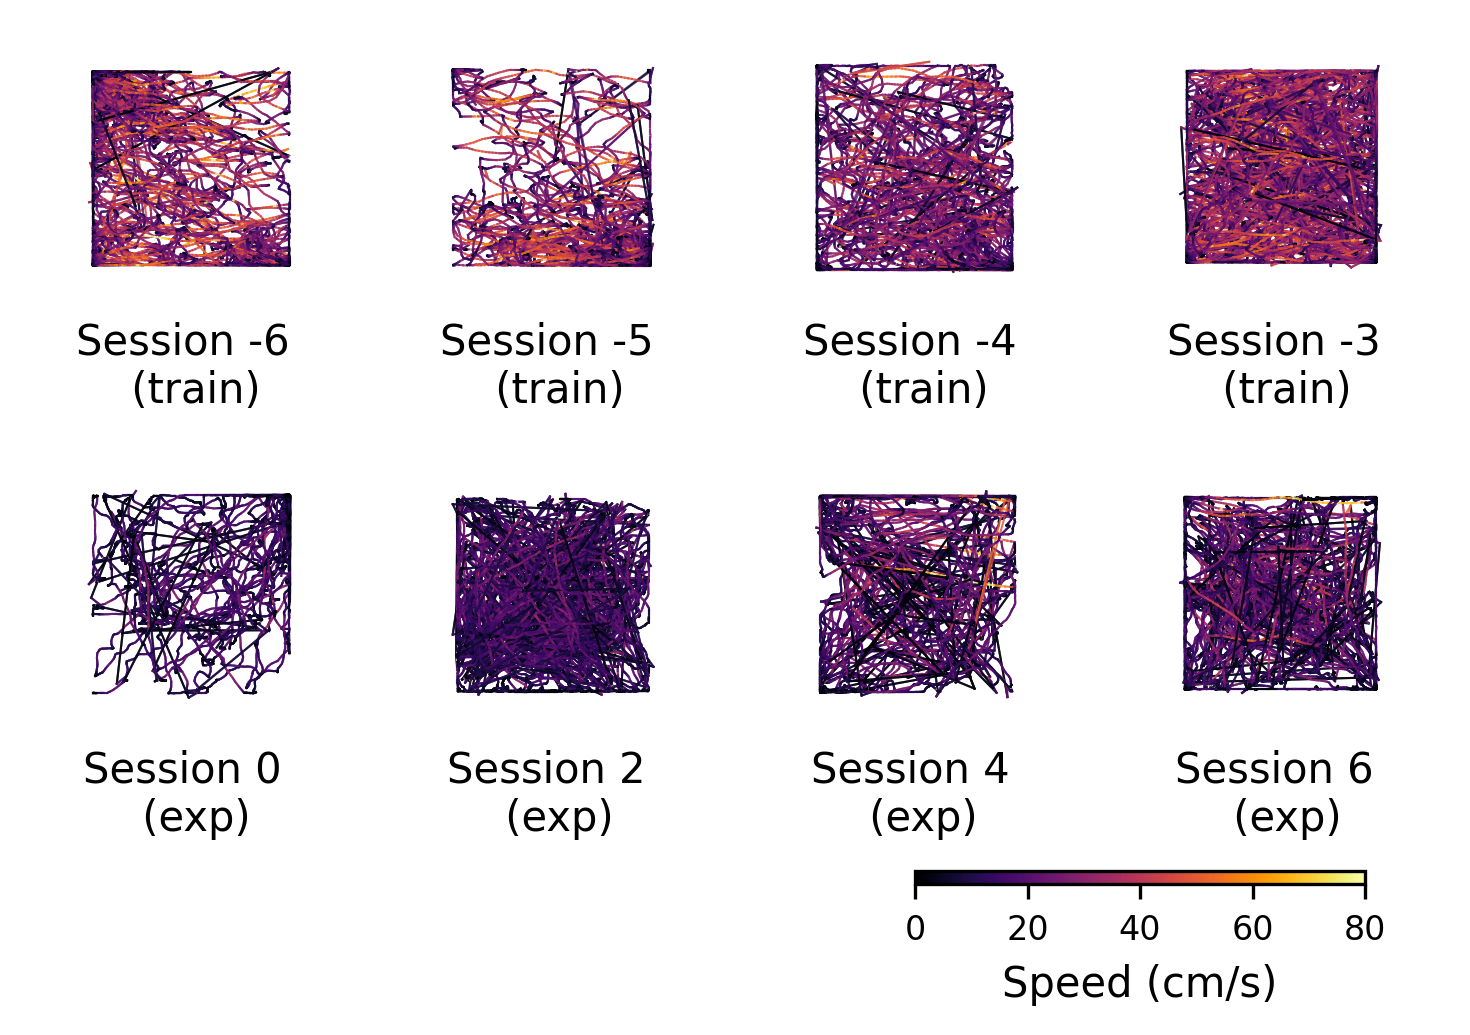

In [11]:
#plot the trajectory as well as behavior outcomes

trajectory_for_plot = {}
max_speed = []

duration = 1200

plot_ind = 0
labels = ['Session -6 \n (train)', 
          'Session -5 \n (train)', 
          'Session -4 \n (train)', 
          'Session -3 \n (train)', 
          'Session 0 \n (exp)', 
          'Session 2 \n (exp)', 
          'Session 4 \n (exp)', 
          'Session 6 \n (exp)']

datafolder = '/home/zilong/Desktop/2D2P/Data/183/183_training/'
#get all txt files in the folder
txt_files = glob.glob(datafolder + '*.txt')
#sort the files according to the date
txt_files.sort()
#for each file, get the trajectory
for i, file in enumerate(txt_files):
    times, x, z, speed = get_trajectory(file, duration)
    #if i in 0, 3, 6, save the trajectory to a dictionary
    if i in [0, 1, 2, 3]:
        max_speed.append(np.max(speed))
        trajectory_for_plot[plot_ind] = [times, x, z, speed]
        plot_ind += 1
        
datafolder = '/home/zilong/Desktop/2D2P/Data/183/183_exp/' 
#get all txt files in the folder
txt_files = glob.glob(datafolder + '*.txt')
#sort the files according to the date
txt_files.sort()

#for each file, get the trajectory
for i, file in enumerate(txt_files):
    times, x, z, speed = get_trajectory(file, duration)
    #if i in 0, 2, save the trajectory to a dictionary
    if i in [0, 2, 4, 6]:
        max_speed.append(np.max(speed))
        trajectory_for_plot[plot_ind] = [times, x, z, speed]
        plot_ind += 1

fig = plt.figure(figsize=(5, 3), dpi=300)
labelsize = 10
ticksize = 8

gs = fig.add_gridspec(2, 4, width_ratios = [1, 1, 1, 1], height_ratios = [1, 1])

# Create a ScalarMappable to map speed values to colors
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=0, vmax=np.max(max_speed)))
sm.set_array([])  # Dummy array for ScalarMappable

#plot 6 trajectories in the first three colums and two rows
for i in range(len(trajectory_for_plot)):
    print("plot trajectory: " + str(i))
    axi = fig.add_subplot(gs[i//4, i%4])
    times, x, z, speed = trajectory_for_plot[i]
    # Plot the trajectory with lines using x and z, with line color based on speed
    for j in range(len(x) - 1):
        axi.plot([x[j], x[j+1]], [z[j], z[j+1]], color=sm.to_rgba(speed[j]), linewidth=0.5, alpha=0.8)
    axi.set_xlabel(labels[i], fontsize=labelsize)
    axi.set_xticks([]); axi.set_yticks([])
    #spines off
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.spines['bottom'].set_visible(False)
    axi.spines['left'].set_visible(False)
    #axi.set_xlim([0, 1]); axi.set_ylim([0, 1])
    #equal axis
    axi.axis('equal')
    
# # Add a colorbar at the right of the subplots
cax = fig.add_axes([0.62, -0.0, 0.3, 0.015])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Speed (cm/s)', fontsize=labelsize)
#set tick size
cbar.ax.tick_params(labelsize=ticksize)

plt.tight_layout()

plt.savefig('../Figures/Figure1_behavior_traj.png', dpi=300)

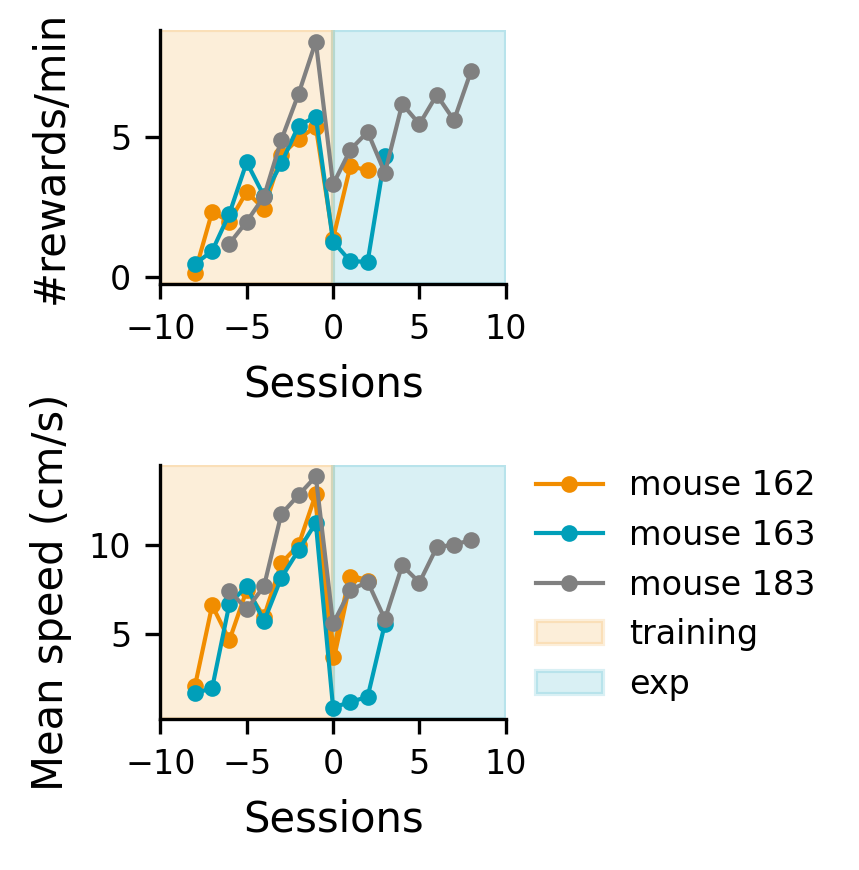

In [14]:

fig = plt.figure(figsize=(3, 3), dpi=300)
labelsize = 10
ticksize = 8

gs = fig.add_gridspec(2, 1)

#get reward rate for mouse 162
reward_rate_training = outcomes_162['reward_rate']['training']
reward_rate_exp = outcomes_162['reward_rate']['exp']

#get reward rate for mouse 163
reward_rate_training_2 = outcomes_163['reward_rate']['training']
reward_rate_exp_2 = outcomes_163['reward_rate']['exp']

#get reward rate for mouse 183
reward_rate_training_4 = outcomes_183['reward_rate']['training']
reward_rate_exp_4 = outcomes_183['reward_rate']['exp']

#get speed for mouse 162
speed_training = outcomes_162['speed']['training']
speed_exp = outcomes_162['speed']['exp']

#get speed for mouse 163
speed_training_2 = outcomes_163['speed']['training']
speed_exp_2 = outcomes_163['speed']['exp']

#get speed for mouse 183
speed_training_4 = outcomes_183['speed']['training']
speed_exp_4 = outcomes_183['speed']['exp']

#select 5 colors sampled from tab10 colormap
# colors = plt.cm.Set2(np.linspace(0, 1, 8))
colors = ['#F18D00', '#009FB9', 'grey']
ms = 3
lw = 1
ls = '-'
mouse_labels = ['mouse 162', 'mouse 163', 'mouse 183']
#mouse_labels = ['animal 1', 'animal 2', 'animal 3', 'animal 4', 'animal 5']

#plot the behavioral outcomes in the last column
ax1 = fig.add_subplot(gs[0,0])

#in ax1 plot the reward rate
ax1.plot(np.arange(-len(reward_rate_training), 0), reward_rate_training, marker='o', markersize=ms, linestyle=ls, color=colors[0], label=mouse_labels[0], linewidth=lw)
ax1.plot(np.arange(0, len(reward_rate_exp)), reward_rate_exp, marker='o', markersize=ms, linestyle=ls, color=colors[0], linewidth=lw)
ax1.plot([-1, 0], [reward_rate_training[-1], reward_rate_exp[0]], color=colors[0], linestyle=ls, linewidth=lw)

ax1.plot(np.arange(-len(reward_rate_training_2), 0), reward_rate_training_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], label=mouse_labels[1], linewidth=lw)
ax1.plot(np.arange(0, len(reward_rate_exp_2)), reward_rate_exp_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], linewidth=lw)
ax1.plot([-1, 0], [reward_rate_training_2[-1], reward_rate_exp_2[0]], color=colors[1], linestyle=ls, linewidth=lw)

ax1.plot(np.arange(-len(reward_rate_training_4), 0), reward_rate_training_4, marker='o', markersize=ms, linestyle=ls, color=colors[2], label=mouse_labels[2], linewidth=lw)
ax1.plot(np.arange(0, len(reward_rate_exp_4)), reward_rate_exp_4, marker='o', markersize=ms, linestyle=ls, color=colors[2], linewidth=lw)
ax1.plot([-1, 0], [reward_rate_training_4[-1], reward_rate_exp_4[0]], color=colors[2], linestyle=ls, linewidth=lw)

#add a shadow area splittinmg negative and positive planes
ax1.axvspan(-10, 0, alpha=0.15, color='#F18D00')
ax1.axvspan(0, 10, alpha=0.15, color='#009FB9')

#set legend on the right side and with 1 column, I want to put the legend out of the plot in case to overllapping with the plot
#axs[0].legend(fontsize=ticksize, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
ax1.set_xticks(np.arange(-10, 12, 5))
ax1.set_xlim([-10, 10])
ax1.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.set_xlabel('Sessions', fontsize=labelsize)
ax1.set_ylabel('#rewards/min', fontsize=labelsize)
# #yticks as scientific notation
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#tick label size
ax1.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = fig.add_subplot(gs[1, 0])

#in ax2 plot the speed
ax2.plot(np.arange(-len(speed_training), 0), speed_training, marker='o', markersize=ms, linestyle=ls, color=colors[0], label=mouse_labels[0], linewidth=lw)
ax2.plot(np.arange(0, len(speed_exp)), speed_exp, marker='o', markersize=ms, linestyle=ls, color=colors[0])
ax2.plot([-1, 0], [speed_training[-1], speed_exp[0]], color=colors[0], linestyle=ls)

ax2.plot(np.arange(-len(speed_training_2), 0), speed_training_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], label=mouse_labels[1], linewidth=lw)
ax2.plot(np.arange(0, len(speed_exp_2)), speed_exp_2, marker='o', markersize=ms, linestyle=ls, color=colors[1], linewidth=lw)
ax2.plot([-1, 0], [speed_training_2[-1], speed_exp_2[0]], color=colors[1], linestyle=ls, linewidth=lw)

ax2.plot(np.arange(-len(speed_training_4), 0), speed_training_4, marker='o', markersize=ms, linestyle=ls, color=colors[2], label=mouse_labels[2], linewidth=lw)
ax2.plot(np.arange(0, len(speed_exp_4)), speed_exp_4, marker='o', markersize=ms, linestyle=ls, color=colors[2], linewidth=lw)
ax2.plot([-1, 0], [speed_training_4[-1], speed_exp_4[0]], color=colors[2], linestyle=ls, linewidth=lw)


#add a shadow area splittinmg negative and positive planes
ax2.axvspan(-10, 0, alpha=0.15, color='#F18D00', label='training')
ax2.axvspan(0, 10, alpha=0.15, color='#009FB9', label='exp')

ax2.set_xticks(np.arange(-10, 12, 5))
ax2.set_xlim([-10, 10])
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
ax2.set_xlabel('Sessions', fontsize=labelsize)
ax2.set_ylabel('Mean speed (cm/s)', fontsize=labelsize)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#create a  legend in 4 column on the top of the plot, outside the plot
ax2.legend(fontsize=ticksize, loc='upper left', bbox_to_anchor=(1, 1.1), ncol=1, frameon=False)

#align the ylabels vertically 
fig.align_ylabels()

plt.tight_layout()

plt.savefig('../Figures/Figure1_behavior_outcome.pdf', dpi=300)